In [1]:
import qiskit
print(qiskit.version.get_version_info())
from qiskit import QuantumCircuit
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.circuit import Parameter

1.1.1


In [7]:
# Step 1 -- Distributable Quantum Circuit
# Input: N/D.
# Output: `circuit`.

def constructQVC(n, k):    
    # Create a quantum circuit with 3 qubits
    num_qubits = n
    depth = k
    qc = QuantumCircuit(num_qubits)

    for i in range(k):
        # Add parameterized rotation gates
        for qubit in range(num_qubits):
            qc.ry(0, qubit)
        
        # Add a layer of CNOT gates (entangling layer)
        for qubit in range(num_qubits - 1):
            qc.cx(qubit, qubit + 1)

    return qc

circuit = constructQVC(6, 2)
print(circuit)

     ┌───────┐     ┌───────┐                                              
q_0: ┤ Ry(0) ├──■──┤ Ry(0) ├─────────────■────────────────────────────────
     ├───────┤┌─┴─┐└───────┘┌───────┐  ┌─┴─┐                              
q_1: ┤ Ry(0) ├┤ X ├────■────┤ Ry(0) ├──┤ X ├──────■───────────────────────
     ├───────┤└───┘  ┌─┴─┐  └───────┘┌─┴───┴─┐  ┌─┴─┐                     
q_2: ┤ Ry(0) ├───────┤ X ├──────■────┤ Ry(0) ├──┤ X ├──────■──────────────
     ├───────┤       └───┘    ┌─┴─┐  └───────┘┌─┴───┴─┐  ┌─┴─┐            
q_3: ┤ Ry(0) ├────────────────┤ X ├──────■────┤ Ry(0) ├──┤ X ├────■───────
     ├───────┤                └───┘    ┌─┴─┐  └───────┘┌─┴───┴─┐┌─┴─┐     
q_4: ┤ Ry(0) ├─────────────────────────┤ X ├──────■────┤ Ry(0) ├┤ X ├──■──
     ├───────┤                         └───┘    ┌─┴─┐  ├───────┤└───┘┌─┴─┐
q_5: ┤ Ry(0) ├──────────────────────────────────┤ X ├──┤ Ry(0) ├─────┤ X ├
     └───────┘                                  └───┘  └───────┘     └───┘


In [3]:
qubits = QuantumRegister(4)
clbits = ClassicalRegister(4)
circuit = QuantumCircuit(qubits, clbits)
(q0, q1, q2, q3) = qubits
(c0, c1, c2, c3) = clbits

circuit.h(q1)
circuit.cx(q1, q2)
circuit.cx(q3, q2)
circuit.measure(q2, c2)
with circuit.if_test((0, 1)):
    circuit.x(q1)
    circuit.x(q2)
circuit.cu(0, 0, 0, 0, [1], [0])
circuit.h(q1)
circuit.measure(q1, c1)
with circuit.if_test((0, 1)):
    circuit.z(q1)
    circuit.x(q3)
circuit.measure(q0, c0)

print(circuit)

#backend = AerSimulator()
#result=backend.run(qc).result()
#counts = result.get_counts()
#print(counts)

                                                   ┌────────────┐        »
q0_0: ─────────────────────────────────────────────┤ U(0,0,0,0) ├────────»
      ┌───┐               ┌──────   ┌───┐ ───────┐ └─────┬──────┘┌───┐┌─┐»
q0_1: ┤ H ├──■────────────┤       ──┤ X ├        ├───────■───────┤ H ├┤M├»
      └───┘┌─┴─┐┌───┐┌─┐  │ If-0    ├───┤  End-0 │               └───┘└╥┘»
q0_2: ─────┤ X ├┤ X ├┤M├──┤       ──┤ X ├        ├─────────────────────╫─»
           └───┘└─┬─┘└╥┘  └──╥───   └───┘ ───────┘                     ║ »
q0_3: ────────────■───╫──────╫─────────────────────────────────────────╫─»
                      ║ ┌────╨─────┐                                   ║ »
c0: 4/════════════════╩═╡ c0_0=0x1 ╞═══════════════════════════════════╩═»
                      2 └──────────┘                                   1 »
«                                 ┌─┐
«q0_0: ───────────────────────────┤M├
«        ┌──────   ┌───┐ ───────┐ └╥┘
«q0_1: ──┤       ──┤ Z ├        ├──╫─
«        │         └───

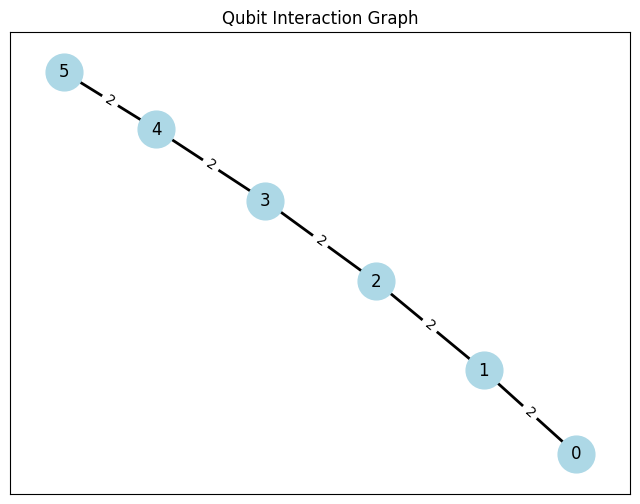

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

def create_qubit_interaction_graph(circuit):
    """Creates a graph based on the quantum circuit where nodes are qubits and edges
    are weighted by the number of 2-qubit gates between them."""
    
    # Initialize a graph
    G = nx.Graph()
    
    # Add nodes for each qubit
    for qubit in range(circuit.num_qubits):
        G.add_node(qubit)
    
    # Iterate through the circuit to find 2-qubit gates and update edge weights
    for gate in circuit.data:
        if len(gate[1]) == 2:  # If the gate acts on two qubits
            qubit1 = circuit.find_bit(gate[1][0])[0]
            qubit2 = circuit.find_bit(gate[1][1])[0]            
            if G.has_edge(qubit1, qubit2):
                G[qubit1][qubit2]['weight'] += 1
            else:
                G.add_edge(qubit1, qubit2, weight=1)

    return G

def get_color(index):
    if index == 0:
        return 'lightblue'
    elif index == 1:
        return 'lightpink'
    elif index == 2:
        return 'lightgreen'
    else:
        return 'lightgray'

def plot_qubit_interaction_graph(G, title, clusters = None):
    """Plots the qubit interaction graph."""
    pos = nx.spring_layout(G)  # Layout for a visually appealing graph
    plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
    
    # Draw nodes
    if clusters is None:
        nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=700)
    else:
        color = 0
        for cluster in clusters:
            nx.draw_networkx_nodes(G, pos, nodelist=cluster, node_color=get_color(color), node_size=700)
            color = color + 1
    nx.draw_networkx_labels(G, pos, font_size=12, font_color='black')
    
    # Draw edges with weights
    edges = G.edges(data=True)
    weights = [d['weight'] for (u, v, d) in edges]
    
    if edges:  # Ensure there are edges to draw
        nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights)
        edge_labels = {(u, v): d['weight'] for u, v, d in edges}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    
    plt.title(title)
    plt.show()

# Create the qubit interaction graph
G = create_qubit_interaction_graph(circuit)

# Plot the graph
plot_qubit_interaction_graph(G, "Qubit Interaction Graph")

[[0, 1, 2, 3], [4, 5]]


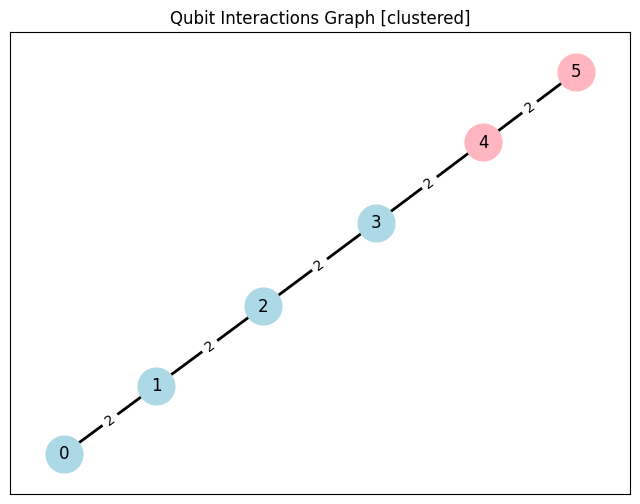

In [10]:
# Step 2 -- Break down algorithm
# Input: `circuit`.
# Output: `distribution_map`.

import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community.quality import modularity
from itertools import combinations
import random

def calculate_edge_cut(G, nodes1, nodes2):
    cut_value = 0
    for u in nodes1:
        for v in nodes2:
            if G.has_edge(u, v):
                cut_value += G[u][v].get('weight')
    return cut_value

def divide_graph(G, n):
    communities = list(greedy_modularity_communities(G, weight='weight', cutoff=n, best_n=n))
    return [list(f) for f in communities]

clusters = divide_graph(G, 2)
print(clusters)

plot_qubit_interaction_graph(G, "Qubit Interactions Graph [clustered]", clusters)

In [12]:
# Step 3 -- Run with distributed system simulator
# Input: `circuit`, `clusters`.
# Output: N/D.

from itertools import product   
from itertools import permutations        
from itertools import combinations
from qiskit.compiler.transpiler import CouplingMap, transpile
from qiskit_aer import AerSimulator

map = clusters
qc = circuit

cm = CouplingMap()
for i in range(qc.num_qubits):
    cm.add_physical_qubit(i)

for i in range(len(clusters)):
    for j in range(len(map[i])):
        for k in range(j+1,len(map[i])):
            cm.add_edge(map[i][j],map[i][k])

for i in range(len(map)):
    for j in range(i+1, len(map)):
        cm.add_edge(map[i][0],map[j][0])

print("Coupling map:", cm.get_edges())

simulator = AerSimulator()
transpiled_distributed_qc=transpile(qc, backend=simulator,coupling_map=cm)

distributed_result=simulator.run(transpiled_distributed_qc).result()
print(distributed_result.get_counts())

Coupling map: EdgeList[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3), (4, 5), (0, 4)]


QiskitError: 'No counts for experiment "0"'